# Time Series Analysis with Prophet model

In [91]:
import pandas as pd
import numpy as np
from prophet import Prophet

import seaborn as sns
import matplotlib.pyplot as plt

from prophet.plot import plot_plotly, plot_components_plotly

from sklearn.metrics import mean_squared_error

from prophet.diagnostics import performance_metrics

import plotly.io as pio
pio.renderers.default = "notebook"

from IPython.display import display

# for model saving/loading
from prophet.serialize import model_from_json, model_to_json
import json
import datetime


sns.axes_style("darkgrid")
sns.set_theme()

In [2]:
# import train data and format timestamp column
df = pd.read_csv('../data/cleaned_sensors_dwd_train.csv', index_col=0)
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [3]:
# import test data
df_test_data = pd.read_csv('../data/cleaned_sensors_dwd_test.csv', index_col=0)
df_test_data['timestamp'] = pd.to_datetime(df_test_data['timestamp'])

In [4]:
# list of locations
#location_list_reg = df['location_id'].unique().tolist()
location_list_reg = [2, 182]

# calculate moving average of training data for cap and floor determination
df_average = df[['location_id', 'timestamp', 'PM2p5']]

# calculate mean of 5 values
df_average['PM2p5_average'] = (df_average.groupby('location_id')['PM2p5'].shift(-2) + df_average.groupby('location_id')['PM2p5'].shift(-1) + df_average.groupby('location_id')['PM2p5'].shift(0) + df_average.groupby('location_id')['PM2p5'].shift(1) + df_average.groupby('location_id')['PM2p5'].shift(2)) /5

# calculate cap and floor for growth = logistic
cap = df_average[['PM2p5_average']].quantile(0.99)[0]
floor = df_average[['PM2p5_average']].min()[0]


/var/folders/4r/hhzzxk3d5mvc86d6wwqtl0940000gn/T/ipykernel_951/2481217595.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Prophet with regressors

In [5]:
#df.head()

In [6]:
# first regressor is temperature_dwd
df_prophet_reg = df[['timestamp','PM2p5','location_id', 'humidity_dwd', 'temperature_dwd', 'pressure_dwd', 'wind_speed', 'precip', 'wind_direction']]  
df_prophet_reg.rename(columns={'timestamp': 'ds', 'PM2p5': 'y', 'humidity_dwd': 'humi', 'temperature_dwd': 'temp', 'pressure_dwd': 'press', 'wind_speed': 'windsp', 'precip': 'precip', 'wind_direction': 'wind_direction'}, inplace=True) #

# drop nans
print(df_prophet_reg.isna().sum())
df_prophet_reg.dropna(inplace=True)


# add cap and floor for growth=logistic
df_prophet_reg['cap'] = cap
df_prophet_reg['floor'] = floor

ds                     0
y                 124923
location_id            0
humi                2040
temp                2040
press               2020
windsp              8618
precip              5842
wind_direction      2020
dtype: int64


/Users/kirstensunder/neuefische/air-pollution/.venv/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/kirstensunder/neuefische/air-pollution/.venv/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/4r/hhzzxk3d5mvc86d6wwqtl0940000gn/T/ipykernel_951/2488018237.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [7]:
NUMBER_OF_MODELS_REG = len(location_list_reg)

In [8]:
# create dictionary to later save models
prophet_models_per_location_reg = {}

seasonality_mode='additive'
yearly_seasonality=True
weekly_seasonality=True
daily_seasonality=True
growth='logistic'
n_changepoints=20

# loop over location ids
for n, location_id in enumerate(location_list_reg[:NUMBER_OF_MODELS_REG]):
    # only take first 5 locations for test
    print('-----'*10)
    print(f'no: {n + 1}, location_id: {location_id}')

    # limit dataframe to specific location_id
    df_location_reg = df_prophet_reg[df_prophet_reg['location_id'] == location_id]
    df_location_reg.drop('location_id', axis=1, inplace=True)

    # init Prophet model and fit it to train data for one location
    model_reg = Prophet(seasonality_mode=seasonality_mode, yearly_seasonality=yearly_seasonality, weekly_seasonality=weekly_seasonality,
                     daily_seasonality=daily_seasonality, growth=growth,n_changepoints=n_changepoints)
    model_reg.add_regressor('temp', standardize=True, prior_scale=0.25)
    model_reg.add_regressor('humi', standardize=True, prior_scale=0.30)
    model_reg.add_regressor('press', standardize=True, prior_scale=0.09)
    model_reg.add_regressor('windsp', standardize=True, prior_scale=0.26)
    model_reg.add_regressor('wind_direction', standardize=True, prior_scale=0.09)
    model_reg.fit(df_location_reg)

    # save model in dictionary
    prophet_models_per_location_reg[location_id] = model_reg

/Users/kirstensunder/neuefische/air-pollution/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



--------------------------------------------------
no: 1, location_id: 2
Initial log joint probability = -208.695
--------------------------------------------------
no: 2, location_id: 182
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       43831.6     0.0039436       3684.98      0.4357      0.4357      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       43990.8    0.00793977        1430.1           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       44054.5     0.0549105        6438.6           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       44101.7     0.0120026       641.975           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
   

/Users/kirstensunder/neuefische/air-pollution/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Initial log joint probability = -24.9977
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       60472.1     0.0101358       34332.5           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       62592.7     0.0131777       11395.9           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       62664.6      0.012658       13676.1           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       62770.1    0.00137452       4694.13           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       62813.4    0.00611226       7099.08           1           1      543   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [9]:
def create_regressor_column(ds, train_col, test_col):
    """Get a regressor of train or test data for corresponding timestamp

    Args:
        ds (datetime): timestamp
        train_col (string): column name of regressor in train data
        test_col (string): column name of regressor in test data

    Returns:
        float: regressor value for given timestamp
    """
    
    if ds in df_prophet_reg['ds'].values:
        return df_prophet_reg[df_prophet_reg['ds'] == ds][train_col].values[0]
    elif ds in df_test_data['timestamp'].values:
        return df_test_data[df_test_data['timestamp'] == ds][test_col].values[0]
    else:
        return np.nan
   

In [10]:
# create dictionary to save prediction results
prophet_forecasts_per_location_reg = {}
for location_id in location_list_reg[:NUMBER_OF_MODELS_REG]:
    print('-----'*10)
    print(f'location_id: {location_id}')

    # load model for current location
    model_reg = prophet_models_per_location_reg[location_id]

    # limit test data to current location
    df_test_location = df_test_data[df_test_data['location_id'] == location_id]
    
    # create dataframe for future predictions and predict
    # 240 = bis 11. Jan
    future_reg = model_reg.make_future_dataframe(periods=240, freq='H')
    future_reg['temp'] = future_reg['ds'].apply(create_regressor_column, args=('temp', 'temperature_dwd'))
    future_reg['humi'] = future_reg['ds'].apply(create_regressor_column, args=('humi', 'humidity_dwd'))
    future_reg['press'] = future_reg['ds'].apply(create_regressor_column, args=('press', 'pressure_dwd'))
    future_reg['windsp'] = future_reg['ds'].apply(create_regressor_column, args=('windsp', 'wind_speed'))   
    future_reg['wind_direction'] = future_reg['ds'].apply(create_regressor_column, args=('wind_direction', 'wind_direction'))   
    # drop nans
    future_reg.dropna(inplace=True)
    # cap and floor for growth = logistic
    future_reg['cap'] = cap
    future_reg['floor'] = floor

    forecast_reg = model_reg.predict(future_reg)

    # save predictions in dataframe
    prophet_forecasts_per_location_reg[location_id] = forecast_reg

--------------------------------------------------
location_id: 2
--------------------------------------------------
location_id: 182


In [85]:
def plot_model_with_future(model, forecast, future, file):

    fig = model.plot(forecast, xlabel='Date', ylabel='Value', figsize=(20, 6))
    ax = fig.gca()
    
    sns.scatterplot(data=future, x='timestamp', y='PM2p5', ax=ax, color='green')
    #ax.set_title("Title", size=34)
    plt.title(f'location {location_id}')
    ax.set_xlabel("Date", size=34)
    ax.set_ylabel("PM 2.5 in µg/m³", size=34)
    ax.tick_params(axis="x", labelsize=24)
    ax.tick_params(axis="y", labelsize=24)
    ax.set_ylim(0, cap * 2)
    ax.set_xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2022-01-11'))

    fig.savefig(file, bbox_inches='tight', facecolor="#EEEEEE")

    plt.show()

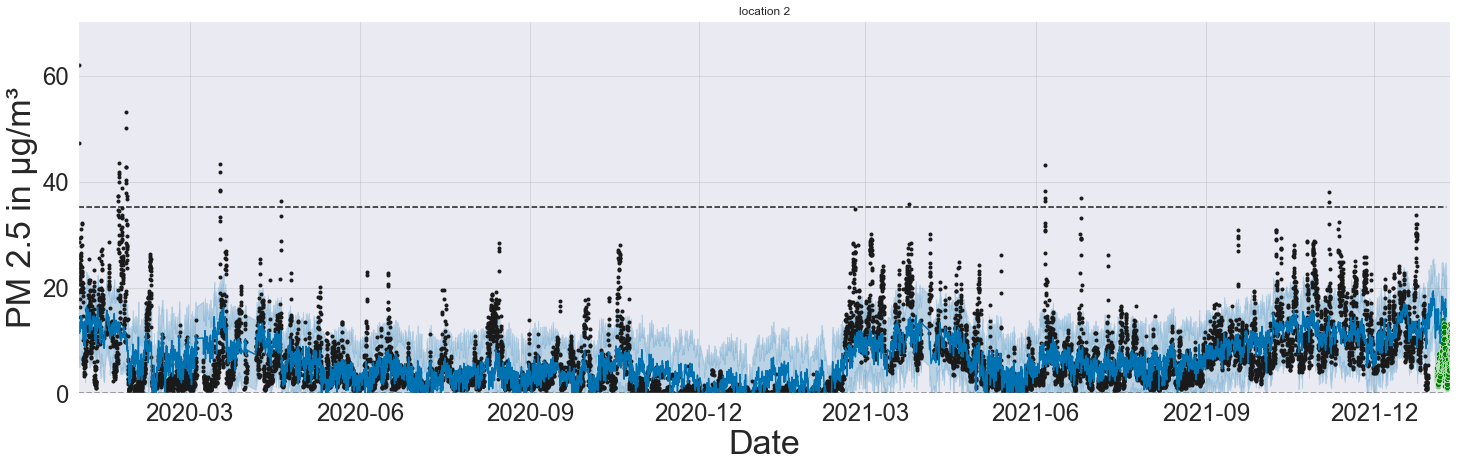

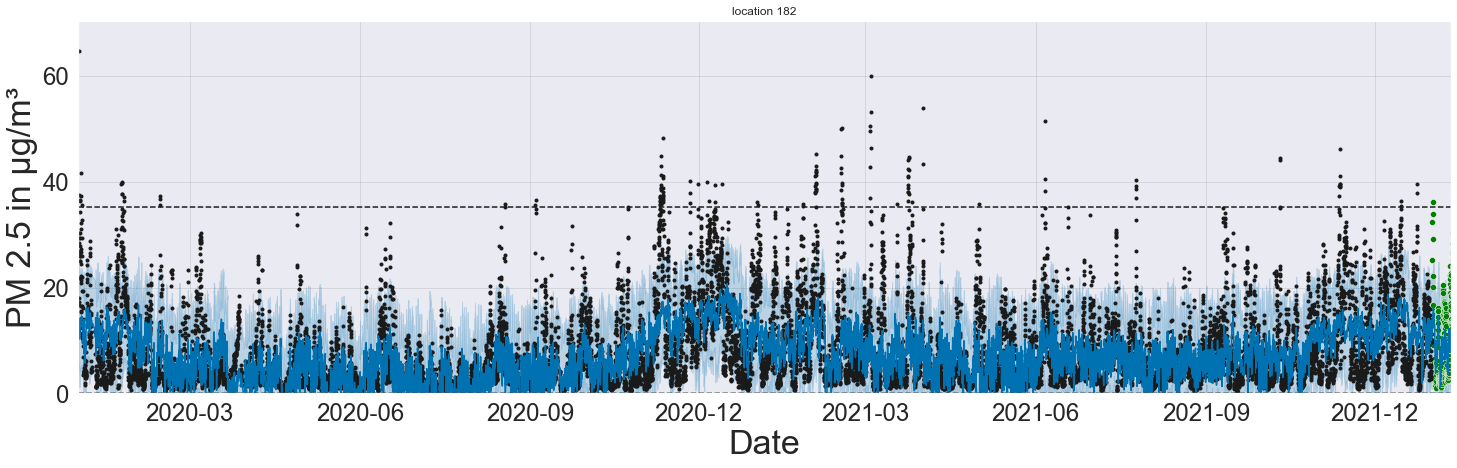

In [86]:
# plot models
for location_id in location_list_reg[:NUMBER_OF_MODELS_REG]:
    model_reg = prophet_models_per_location_reg[location_id]
    # limit test data to current location
    df_test_location = df_test_data[df_test_data['location_id'] == location_id]
    plot_model_with_future(model_reg, prophet_forecasts_per_location_reg[location_id], df_test_location, f'../images/prophet_reg_location_id_{location_id}.png')

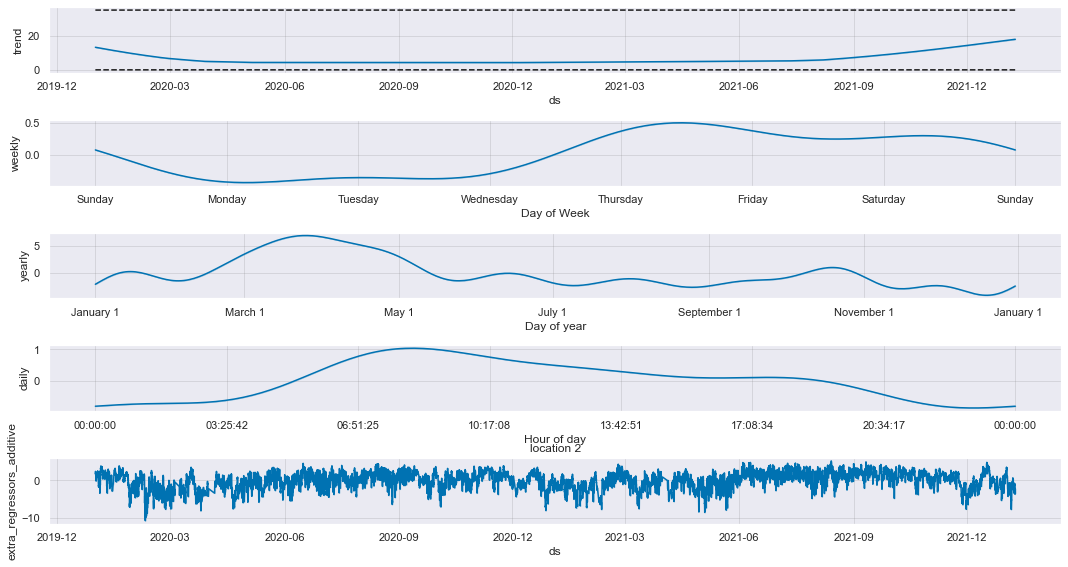

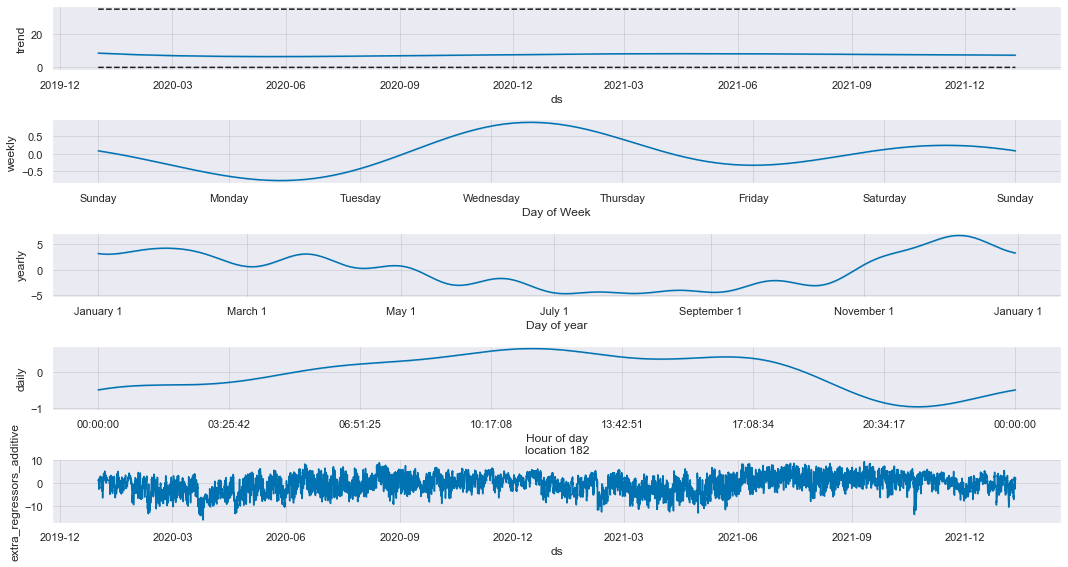

In [13]:
# plot components of models
for location_id in location_list_reg[:NUMBER_OF_MODELS_REG]:
    model_reg = prophet_models_per_location_reg[location_id]
    fig2 = model_reg.plot_components(prophet_forecasts_per_location_reg[location_id], figsize=(15, 8))
    plt.title(f'location {location_id}')

    fig2.savefig(f'../images/prophet_components_reg_location_id_{location_id}.png', bbox_inches='tight', facecolor="#EEEEEE")

In [14]:
# interactive plot for location_id 125 (this does not work in a loop) with regressors
#model_reg = prophet_models_per_location_reg[125]
#plot_plotly(model_reg, prophet_forecasts_per_location_reg[125])


# Calculating RMSE

In [15]:
#df_test_data

In [16]:
number_of_hours = 240

In [53]:
rmse_dict_reg_train = {}
rmse_dict_reg_test = {}

for location in location_list_reg[:NUMBER_OF_MODELS_REG]:
    # limit columns of test data for calculating rmse
    df_rmse_test_reg = df_test_data.query(f"location_id == {location} and timestamp <= '{max(prophet_forecasts_per_location_reg[location].ds)}'")[['timestamp','PM2p5']]
    # use train data for calculating RMSE
    df_rmse_train_reg = df.query(f"location_id == {location}")[['timestamp','PM2p5']]

    # merge forecast to test data
    df_rmse_test_reg = df_rmse_test_reg.merge(prophet_forecasts_per_location_reg[location][['yhat', 'ds']], how='left', left_on='timestamp', right_on='ds').drop(columns='ds', axis=1)
    df_rmse_train_reg = df_rmse_train_reg.merge(prophet_forecasts_per_location_reg[location][['yhat', 'ds']], how='left', left_on='timestamp', right_on='ds').drop(columns='ds', axis=1)

    # drop NaN
    df_rmse_test_reg.dropna(inplace=True)
    df_rmse_train_reg.dropna(inplace=True)

    # calculate rmse for specific time span
    rmse_test_reg = mean_squared_error(df_rmse_test_reg['PM2p5'], df_rmse_test_reg['yhat'], squared=False)
    rmse_train_reg = mean_squared_error(df_rmse_train_reg['PM2p5'], df_rmse_train_reg['yhat'], squared=False)

    #save results
    rmse_dict_reg_test[location] = rmse_test_reg
    rmse_dict_reg_train[location] = rmse_train_reg

    # show results
    print(f'location {location}')
    print(f'RMSE test = {round(rmse_test_reg,2)} µg/m3')
    print(f'RMSE train = {round(rmse_train_reg,2)} µg/m3')
    print('------------' * 2)


location 2
RMSE test = 9.45 µg/m3
RMSE train = 5.02 µg/m3
------------------------
location 182
RMSE test = 6.31 µg/m3
RMSE train = 7.74 µg/m3
------------------------


In [70]:
round(df_rmse_test_reg.rmse_reg.max(),0)


9.0

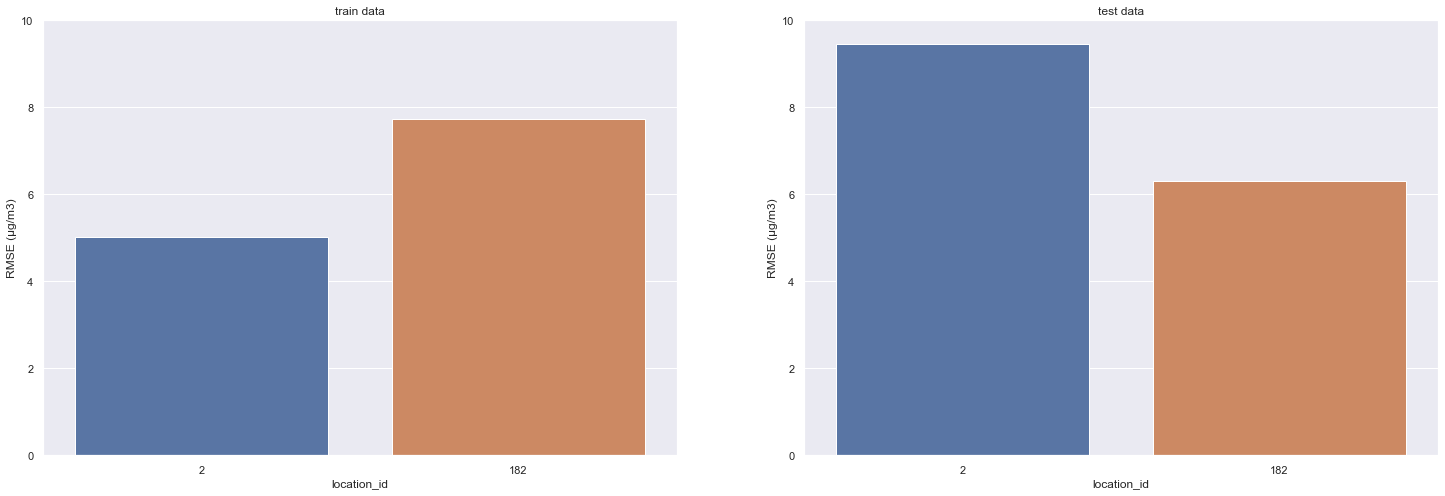

In [87]:
# change dictionary to DataFrame
df_rmse_train_reg = pd.DataFrame.from_dict(data=rmse_dict_reg_train, orient='index')
df_rmse_train_reg.reset_index(inplace=True)
df_rmse_train_reg.columns = ['location_id','rmse_reg']

df_rmse_test_reg = pd.DataFrame.from_dict(data=rmse_dict_reg_test, orient='index')
df_rmse_test_reg.reset_index(inplace=True)
df_rmse_test_reg.columns = ['location_id','rmse_reg']

y_max = df_rmse_test_reg.rmse_reg.max()

# plot ordered by train rmse
plt.figure(figsize=(25,8))
plt.subplot(1,2,1)
sns.barplot(data=df_rmse_train_reg.sort_values('rmse_reg', ascending=False), x='location_id', y='rmse_reg', order=df_rmse_train_reg.sort_values('rmse_reg', ascending=True)['location_id']) # ordered by rmse_reg
plt.title('train data')
plt.ylabel('RMSE (µg/m3)')
plt.ylim(0, round(y_max, 0) + 1)
plt.subplot(1,2,2)
sns.barplot(data=df_rmse_test_reg.sort_values('rmse_reg', ascending=False), x='location_id', y='rmse_reg', order=df_rmse_train_reg.sort_values('rmse_reg', ascending=True)['location_id']) # same order like train data
plt.title('test data')
plt.ylabel('RMSE (µg/m3)')
plt.ylim(0, round(y_max, 0) + 1);


In [48]:
df_rmse_train_reg.to_csv('../models/prophet_rmse.csv')

In [101]:
# save models and forecasts
now = datetime.datetime.now().strftime('%d-%m-%Y_%H:%M')
for location_id in location_list_reg:
    model_json = model_to_json(prophet_models_per_location_reg[location_id])
    with open(f'../models/model_reg_with_prior_scale_{location_id}_{now}.json', 'w') as f:
        json.dump(model_json, f)

    prophet_forecasts_per_location_reg[location_id].to_csv(f'../models/forecast_reg_with_prior_scale_{location_id}_{now}.csv')